- Heart Disease Data 


**Features of the data:**
- id - Unique identifier for each patient.
- Age - Age of the patient (in years)
- Sex - Gender of the patient
- Chest Pain Type - Type of chest pain experienced.
- BP (Blood Pressure) - Resting blood pressure (mm Hg).
- Cholestrol - Serum cholesterol level (mg/dl).
- FBS over 120 - Fasting Blood sugar above 120 mg/dl.
- EKG results - Resting Electrocardiographic Results (Measures heart electrical activity)
- Max HR - Maximum heart rate achieved during exercise.
- Exercise Angina - Chest pain induced by exercise.
- ST depression - an electrocardiogram (ECG) finding where the ST segment sits below the baseline that is induced by exercise relative to rest.
- Slope of ST - Slope of the peak exercise ST segment 
- Number of Vessels Fluro: Number of major vessels (0–3) colored by fluoroscopy.
- Thallium: Result of thallium stress test
- Heart Disease (Target Variable) - Indicates presence of heart disease.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import joblib
import json

In [15]:
pip install xgboost[cuda]

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium                 630000 non-null  int64  
 14  Hear

In [ ]:
df.shape

(630000, 15)

In [ ]:
df.corr

<bound method DataFrame.corr of             id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  \
0            0   58    1                4  152          239             0   
1            1   52    1                1  125          325             0   
2            2   56    0                2  160          188             0   
3            3   44    0                3  134          229             0   
4            4   58    1                4  140          234             0   
...        ...  ...  ...              ...  ...          ...           ...   
629995  629995   56    0                1  110          226             0   
629996  629996   54    1                4  128          249             1   
629997  629997   67    1                4  130          275             0   
629998  629998   52    1                4  140          199             0   
629999  629999   51    0                2  130          199             0   

        EKG results  Max HR  Exercise angin

In [24]:
X = df.drop('Heart Disease', axis=1)

le = LabelEncoder()
df['Heart Disease'] = le.fit_transform(df['Heart Disease'])
y = df['Heart Disease']

<Axes: >

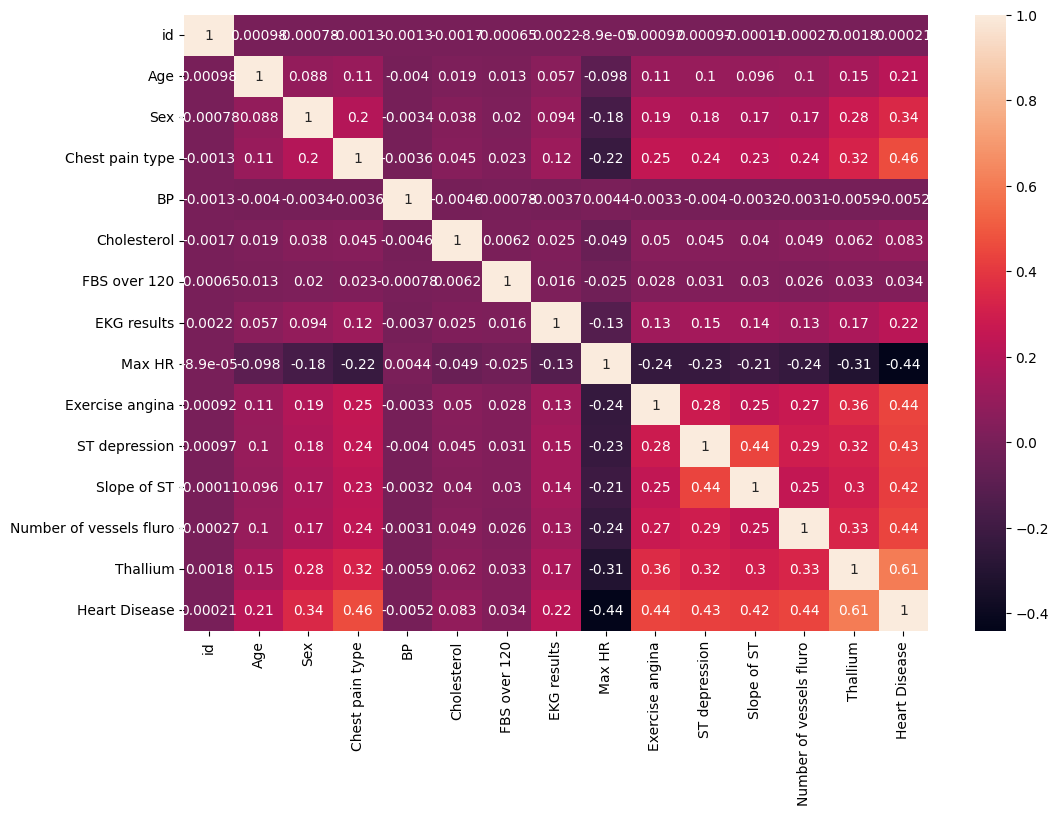

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)

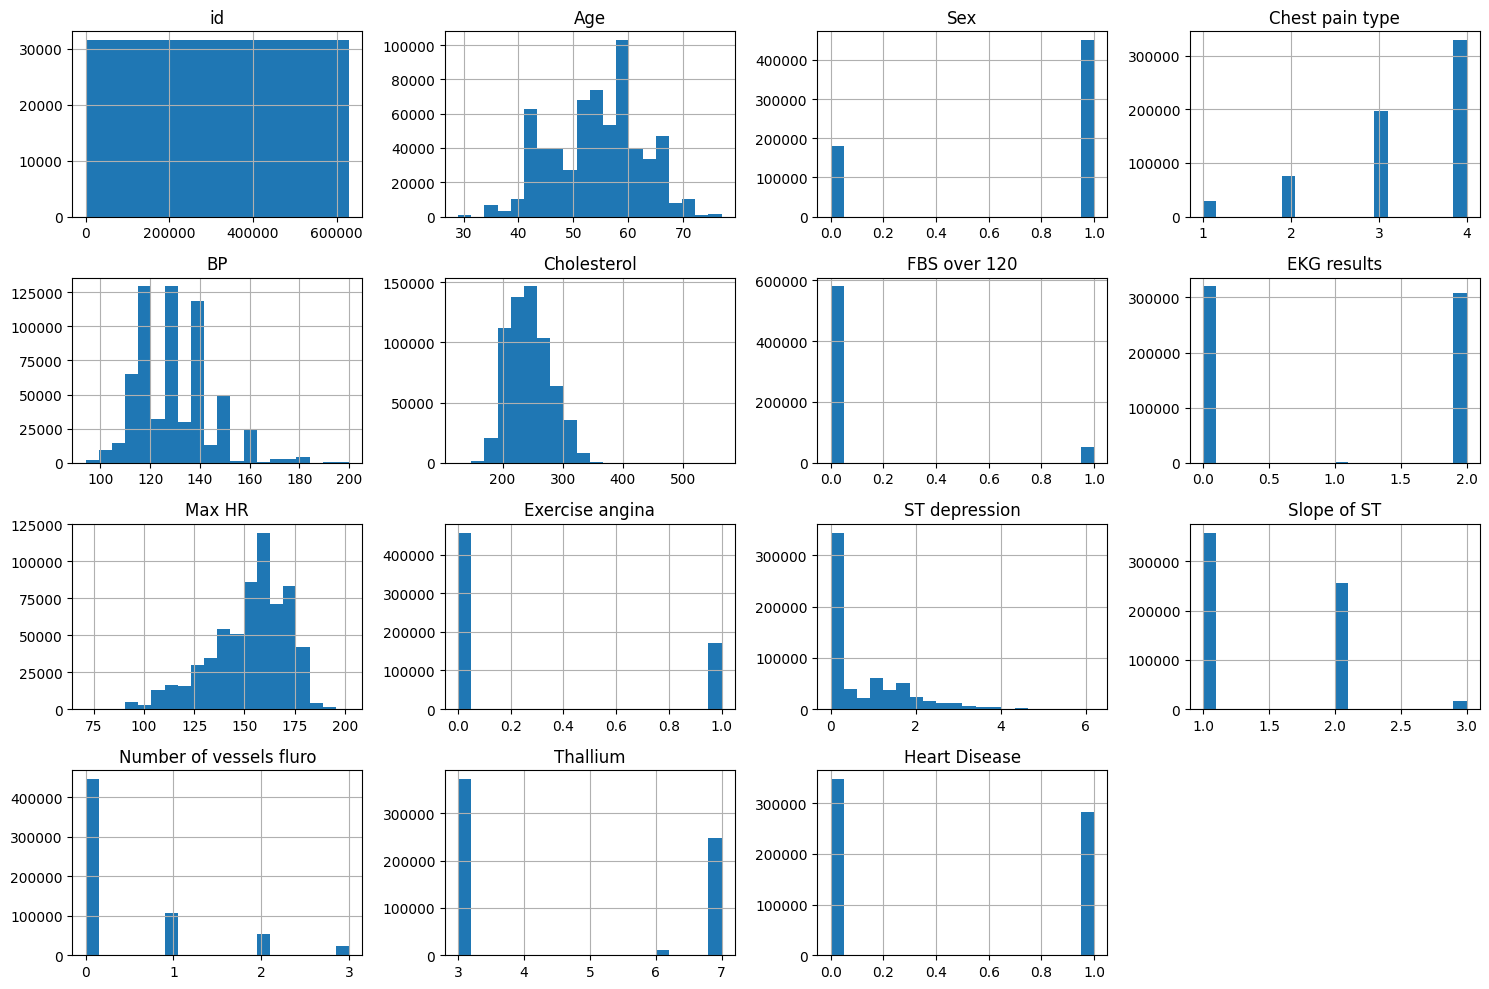

In [ ]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

df[num_cols].hist(figsize=(15,10), bins=20)
plt.tight_layout()
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [ ]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')

roc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score: {roc:.5f}')

Accuracy: 0.88215
ROC AUC Score: 0.94857


In [ ]:
joblib.dump(rf, 'Model/rf.pkl')

['Model/rf.pkl']

<h1> Now with XGBoost </h1>

In [ ]:
neg, pos = (y == 0).sum(), (y == 1).sum()
scale = neg / pos

xgb = XGBClassifier(
    device='cuda',
    tree_method='hist',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale,
    eval_metric='auc',
    early_stopping_rounds=50,   # stops if no improvement for 50 rounds
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100                 # print every 100 rounds
)

[0]	validation_0-auc:0.93535
[100]	validation_0-auc:0.95381
[200]	validation_0-auc:0.95466
[300]	validation_0-auc:0.95498
[400]	validation_0-auc:0.95510
[500]	validation_0-auc:0.95512
[556]	validation_0-auc:0.95510


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",'cuda'
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",50
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [ ]:
y_pred      = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

base_auc = roc_auc_score(y_test, y_pred_prob)
base_acc = accuracy_score(y_test, y_pred)
print(f"\n Accuracy: {base_acc:.4f} | AUC: {base_auc:.4f}")

c:\Users\rahi\Downloads\Bacancy\vpython\Lib\site-packages\xgboost\core.py:751: UserWarning: [13:39:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



 Accuracy: 0.8867 | AUC: 0.9551


In [ ]:
joblib.dump(xgb, 'Model/xgb.pkl')

['Model/xgb.pkl']

c:\Users\rahi\Downloads\Bacancy\vpython\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


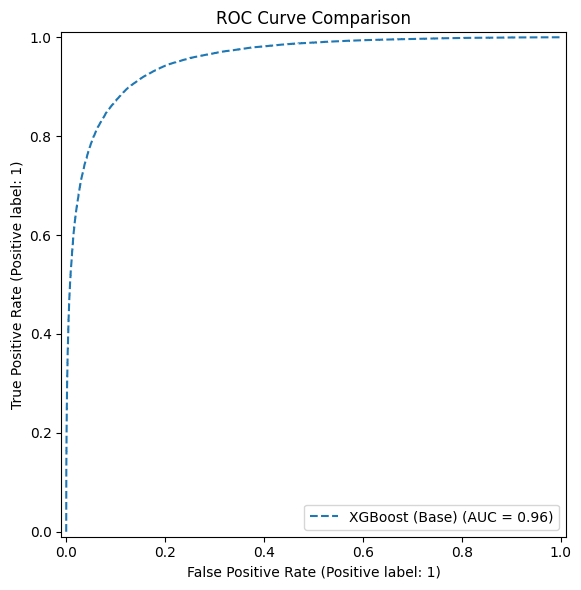

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb, X_test, y_test, ax=ax, name='XGBoost (Base)', linestyle='--')
ax.set_title('ROC Curve Comparison')
plt.tight_layout()
plt.show()

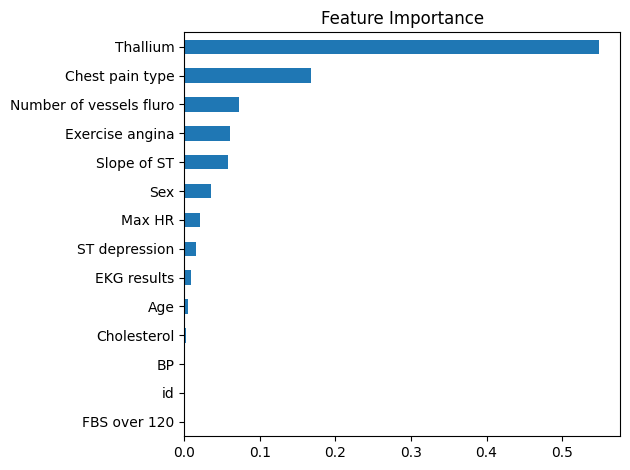

In [ ]:
feat_imp = pd.Series(xgb.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', title='Feature Importance')
plt.tight_layout()

Now Hyperparameter RandomSearch and Data Cleaning <h1>

In [ ]:
df.drop_duplicates(inplace=True)
X= df.drop(['Heart Disease', 'FBS over 120', 'BP'], axis=1)
y = df['Heart Disease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
neg, pos = (y == 0).sum(), (y == 1).sum()
scale = neg / pos

from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators'     : [500, 1000, 1500],
    'max_depth'        : [4, 6, 8, 10],
    'learning_rate'    : [0.01, 0.05, 0.1],
    'subsample'        : [0.7, 0.8, 0.9],
    'colsample_bytree' : [0.7, 0.8, 0.9],
    'min_child_weight' : [1, 3, 5],
    'gamma'            : [0, 0.1, 0.3],        # min loss reduction to split
    'reg_alpha'        : [0, 0.1, 0.5],        # L1 regularization
    'reg_lambda'       : [1, 1.5, 2],          # L2 regularization
}

xgb_tuned = XGBClassifier(
    device='cuda',
    tree_method='hist',
    scale_pos_weight=scale,
    eval_metric='auc',
    random_state=42,
)

search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions=param_dist,
    n_iter=30,              # try 30 random combos
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [10:28:45] WARNING: /__w/xgboost/xgboost/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [10:28:45] WARNING: /__w/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
y_pred_tuned      = best_model.predict(X_test)
y_pred_prob_tuned = best_model.predict_proba(X_test)[:, 1]

tuned_auc = roc_auc_score(y_test, y_pred_prob_tuned)
tuned_acc = accuracy_score(y_test, y_pred_tuned)

print(f"\n Tuned Model ->Accuracy: {tuned_acc:.4f} | AUC: {tuned_auc:.4f}")
print(f"\n Improvement -> AUC: +{tuned_auc - base_auc:.4f}")


 Tuned Model ->Accuracy: 0.8870 | AUC: 0.9552


NameError: name 'base_auc' is not defined

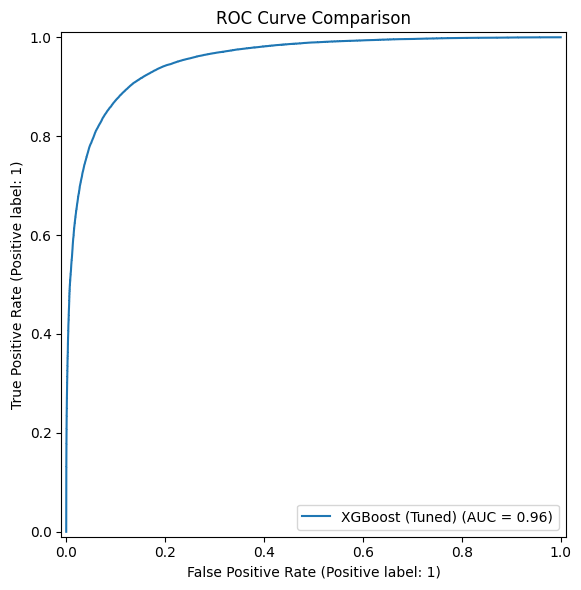

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax, name='XGBoost (Tuned)')
ax.set_title('ROC Curve Comparison')
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(best_model, 'xgb_tuned.pkl')

scores = {
    'tuned_accuracy': round(tuned_acc, 4),
    'tuned_auc'     : round(tuned_auc, 4),
    'best_params'   : search.best_params_
}
with open('model_scores.json', 'w') as f:
    json.dump(scores, f, indent=4)

**CatBoost**  

In [ ]:
pip install catboost

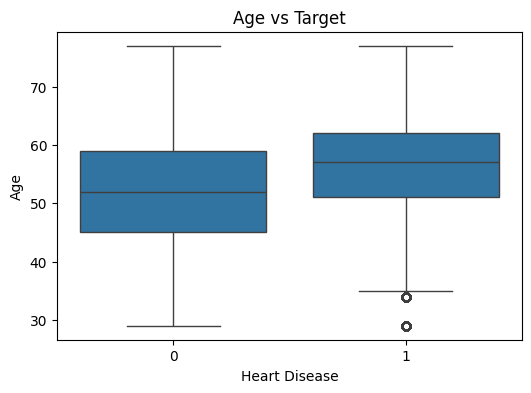

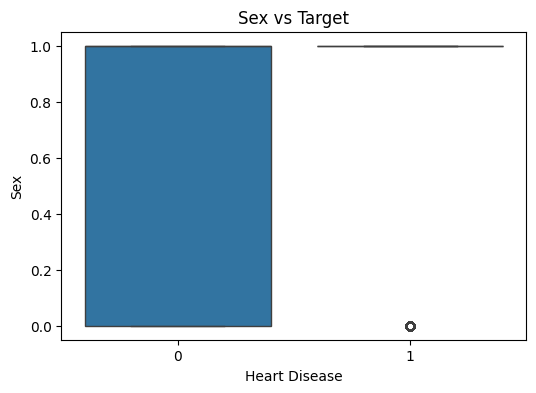

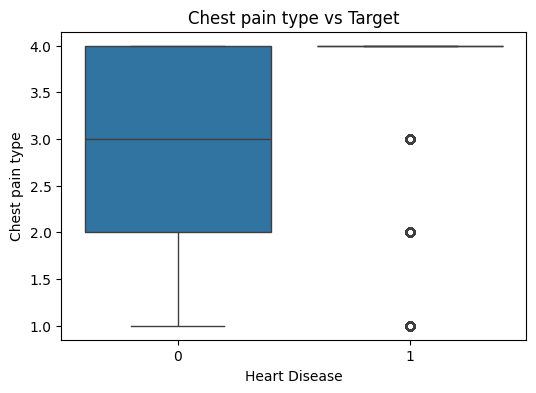

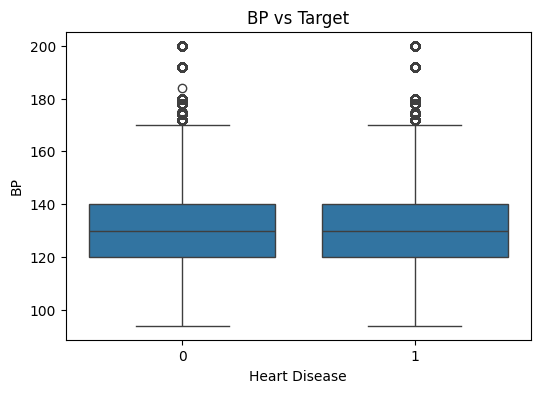

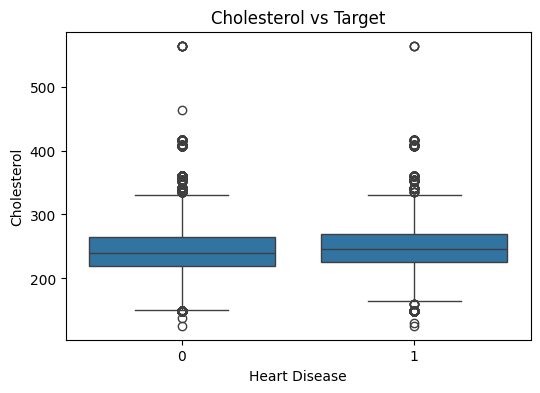

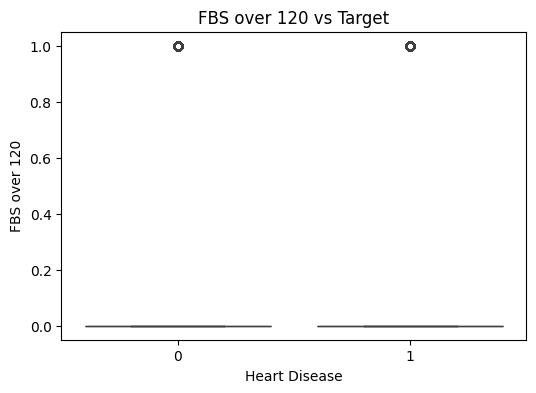

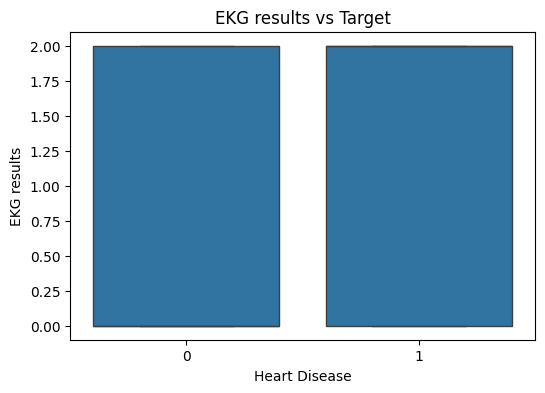

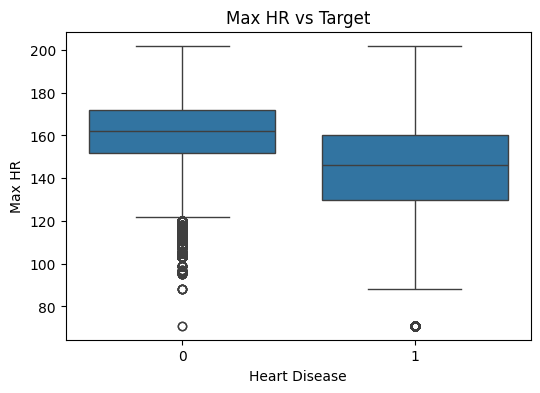

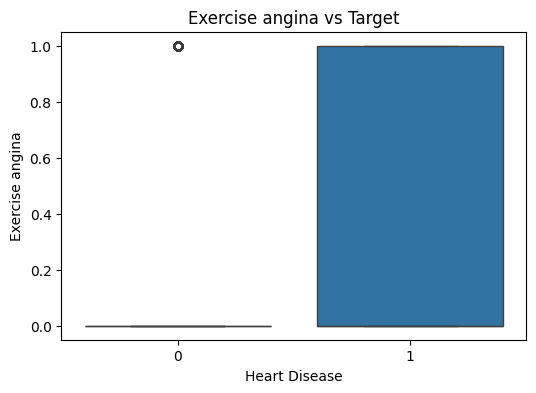

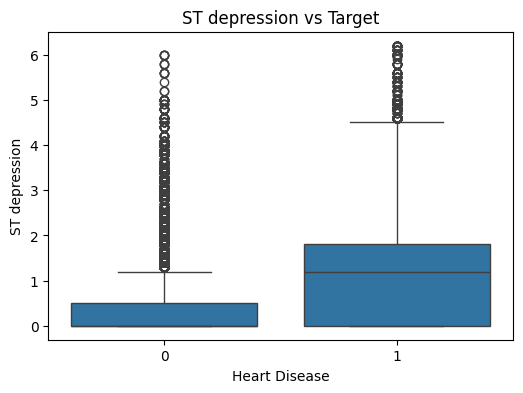

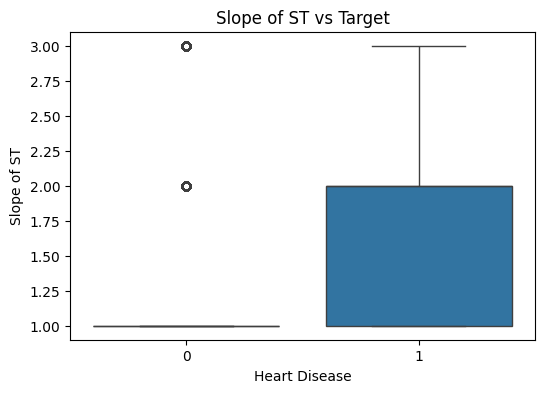

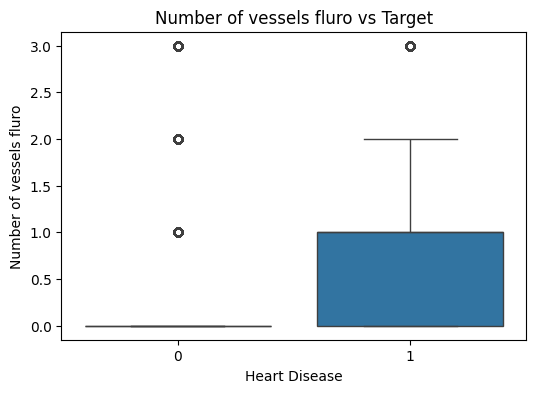

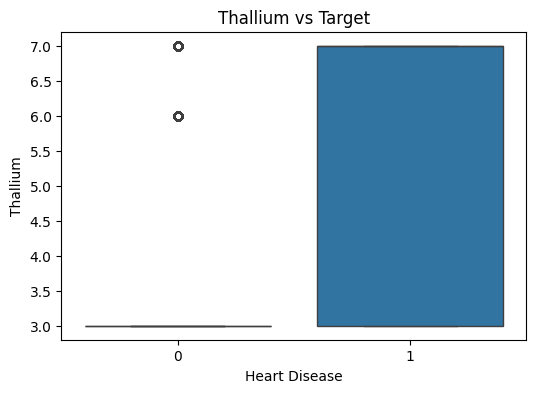

In [19]:
exclude_cols = {'id', 'Heart Disease'}
num_cols = [c for c in num_cols if c not in exclude_cols]

for col in num_cols:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(x="Heart Disease", y=col, data=df)
    plt.title(f"{col} vs Target")
    plt.show()

In [ ]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

catboost_base = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    task_type='CPU',           # Switched to CPU due to CUDA driver incompatibility
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100,
    scale_pos_weight=scale
)

print("\nTraining base model...")


Training base model...


In [ ]:
catboost_base.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    plot=False
)

0:	test: 0.9392679	best: 0.9392679 (0)	total: 40.3ms	remaining: 40.2s
100:	test: 0.9538522	best: 0.9538522 (100)	total: 3.76s	remaining: 33.5s
200:	test: 0.9543665	best: 0.9543665 (200)	total: 7.44s	remaining: 29.6s
300:	test: 0.9546736	best: 0.9546736 (300)	total: 11.1s	remaining: 25.7s
400:	test: 0.9549769	best: 0.9549769 (400)	total: 14.6s	remaining: 21.9s
500:	test: 0.9550986	best: 0.9550986 (500)	total: 18.2s	remaining: 18.2s
600:	test: 0.9551836	best: 0.9551836 (600)	total: 21.9s	remaining: 14.5s
700:	test: 0.9552307	best: 0.9552307 (700)	total: 25.5s	remaining: 10.9s
800:	test: 0.9552592	best: 0.9552597 (788)	total: 29.2s	remaining: 7.24s
900:	test: 0.9552810	best: 0.9552810 (900)	total: 32.8s	remaining: 3.61s
999:	test: 0.9552868	best: 0.9552903 (989)	total: 37s	remaining: 0us

bestTest = 0.9552902806
bestIteration = 989

Shrink model to first 990 iterations.


In [ ]:
y_pred = catboost_base.predict(X_test)
y_pred_prob = catboost_base.predict_proba(X_test)[:, 1]

base_auc = roc_auc_score(y_test, y_pred_prob)
base_acc = accuracy_score(y_test, y_pred)
print(f"\n✓ Base Model → Accuracy: {base_acc:.4f} | AUC: {base_auc:.5f}")

In [ ]:
joblib.dump(catboost_base, 'catboost.pkl')

['catboost.pkl']

In [ ]:
if 'Age' in X.columns:
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 40, 50, 60, 100], labels=[0, 1, 2, 3]).astype(int)

if 'Cholesterol' in X.columns:
    X['Chol_Risk'] = pd.cut(X['Cholesterol'], bins=[0, 200, 240, 1000], labels=[0, 1, 2]).astype(int)

if 'BP' in X.columns:
    X['BP_Risk'] = pd.cut(X['BP'], bins=[0, 120, 140, 300], labels=[0, 1, 2]).astype(int)

if 'Max HR' in X.columns and 'Age' in X.columns:
    X['HR_Reserve'] = X['Max HR'] - X['Age']

if 'BP' in X.columns and 'Cholesterol' in X.columns:
    X['BP_Chol_Product'] = X['BP'] * X['Cholesterol']

if 'Age' in X.columns and 'Cholesterol' in X.columns:
    X['Age_Chol_Product'] = X['Age'] * X['Cholesterol']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

neg, pos = (y == 0).sum(), (y == 1).sum()
scale = neg / pos

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

catboost_base = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    task_type='GPU', 
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100,
    scale_pos_weight=scale
)

catboost_base.fit(train_pool, eval_set=test_pool, use_best_model=True)

y_pred = catboost_base.predict(X_test)
y_pred_prob = catboost_base.predict_proba(X_test)[:, 1]

base_auc = roc_auc_score(y_test, y_pred_prob)
base_acc = accuracy_score(y_test, y_pred)
print(f"\n✓ Accuracy: {base_acc:.4f} | AUC: {base_auc:.4f}")

0:	test: 0.9406340	best: 0.9406340 (0)	total: 42.4ms	remaining: 42.3s
100:	test: 0.9545901	best: 0.9545901 (100)	total: 4.07s	remaining: 36.2s
200:	test: 0.9551500	best: 0.9551500 (200)	total: 7.98s	remaining: 31.7s
300:	test: 0.9555462	best: 0.9555462 (300)	total: 11.9s	remaining: 27.5s
400:	test: 0.9558052	best: 0.9558052 (400)	total: 15.7s	remaining: 23.4s
500:	test: 0.9559313	best: 0.9559313 (500)	total: 19.5s	remaining: 19.4s
600:	test: 0.9560014	best: 0.9560014 (600)	total: 23.4s	remaining: 15.5s
700:	test: 0.9560559	best: 0.9560564 (699)	total: 27.3s	remaining: 11.7s
800:	test: 0.9560863	best: 0.9560883 (765)	total: 31.5s	remaining: 7.83s
900:	test: 0.9561026	best: 0.9561039 (896)	total: 35.5s	remaining: 3.9s
999:	test: 0.9561188	best: 0.9561196 (998)	total: 39.4s	remaining: 0us

bestTest = 0.9561195868
bestIteration = 998

Shrink model to first 999 iterations.

✓ Accuracy: 0.8897 | AUC: 0.9561


In [ ]:
joblib.dump(catboost_base, 'catboostclaude.pkl')

['catboostclaude.pkl']

In [ ]:
from catboost import CatBoostClassifier, Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

catboost_base = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth=5,
    task_type='GPU',          
    devices='0',             
    loss_function='Logloss',
    eval_metric='AUC',
    early_stopping_rounds=300,
    verbose=500,
    # random_seed=42,
    l2_leaf_reg=8,           # L2 regularization
    scale_pos_weight=1
)

catboost_base.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    plot=False
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9329597	best: 0.9329597 (0)	total: 18ms	remaining: 1m 30s
500:	test: 0.9550102	best: 0.9550102 (500)	total: 10.2s	remaining: 1m 31s
1000:	test: 0.9552789	best: 0.9552799 (993)	total: 20.5s	remaining: 1m 21s
1500:	test: 0.9553177	best: 0.9553196 (1481)	total: 30.8s	remaining: 1m 11s
2000:	test: 0.9553251	best: 0.9553283 (1726)	total: 41.1s	remaining: 1m 1s
bestTest = 0.9553283453
bestIteration = 1726
Shrink model to first 1727 iterations.


CatBoostClassifier(depth=5, devices='0', early_stopping_rounds=300, eval_metric='AUC', iterations=5000, l2_leaf_reg=8, learning_rate=0.05, loss_function='Logloss', scale_pos_weight=1, task_type='GPU', verbose=500)

In [ ]:
joblib.dump(catboost_base, 'Model/catfinal.pkl')

['Model/catfinal.pkl']

lightbgm

In [26]:
from lightgbm import LGBMClassifier

lbgm = LGBMClassifier(
    objective='binary',
    metric='auc',
    
    n_estimators=6000,
    learning_rate=0.01,
    
    num_leaves=31,              # default but strong
    max_depth=-1,               # let leaves control complexity
    
    min_child_samples=40,       # prevents overfitting
    min_child_weight=1e-3,
    
    subsample=0.8,
    subsample_freq=1,
    
    colsample_bytree=0.8,
    
    reg_alpha=0.5,
    reg_lambda=2,
    
    random_state=42,
    n_jobs=-1
)

lbgm.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 226018, number of negative: 277982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448448 -> initscore=-0.206942
[LightGBM] [Info] Start training from score -0.206942


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,6000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,40


In [27]:
y_pred = lbgm.predict(X_test)
y_pred_prob = lbgm.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_prob)
acc = accuracy_score(y_test, y_pred)
print(f"\n✓ Accuracy: {acc:.4f} | AUC: {auc:.4f}")


✓ Accuracy: 0.8874 | AUC: 0.9552


In [28]:
joblib.dump(lbgm, 'Model/lgbm.pkl')

['Model/lgbm.pkl']

In [ ]:


model = joblib.load('Model/lgbm.pkl')

test_df = pd.read_csv('test.csv')

# Apply same encoding as train
le_dict = joblib.load('label_encoders.pkl')

for col, le in le_dict.items():
    if col in test_df.columns:         
        test_df[col] = le.transform(test_df[col])


# Predict
test_preds = model.predict_proba(test_df)[:, 1]  

submission = pd.DataFrame({
    'id'           : test_df['id'],
    'Heart Disease': test_preds
})



submission.to_csv('Submission/lgbm_submission.csv', index=False)
print(submission.head(10))
print(f"Submission shape: {submission.shape}")

c:\Users\rahi\Downloads\Bacancy\vpython\Lib\site-packages\sklearn\base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


       id  Heart Disease
0  630000       0.901677
1  630001       0.008956
2  630002       0.980474
3  630003       0.003882
4  630004       0.170407
5  630005       0.978808
6  630006       0.004693
7  630007       0.668504
8  630008       0.988225
9  630009       0.012178
Submission shape: (270000, 2)


In [ ]:
pip install mlflow

  Using cached alembic-1.18.4-py3-none-any.whl.metadata (7.2 kB)
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached cachetools-6.2.6-py3-none-any.whl.metadata (5.6 kB)
  Using cached gitpython-3.1.46-py3-none-any.whl.metadata (13 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   --------- ------------------------------ 2.4/9.7 MB 16.4 MB/s eta 0:00:01
   --------


[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
